# 1.Setup

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import metrics
from sklearn import naive_bayes
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold,  KFold, train_test_split


from google.colab import drive  
drive.mount('/content/gdrive')
train_set= pd.read_csv('/content/gdrive/My Drive/Ride_Fare/train.csv', index_col="tripid")
test_set= pd.read_csv('/content/gdrive/My Drive/Ride_Fare/test.csv', index_col="tripid")    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 2.Feature Engineering

Class 0: 1681
Class 1: 15495
Proportion: 0.11 : 1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   additional_fare     17176 non-null  float64
 1   duration            17176 non-null  float64
 2   meter_waiting       17176 non-null  float64
 3   meter_waiting_fare  17176 non-null  float64
 4   fare                17176 non-null  float64
 5   label               17176 non-null  int64  
 6   distance            17176 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.0 MB


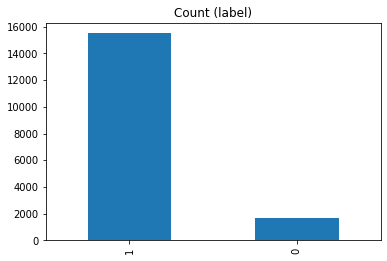

In [6]:
#Label encoding
train_set["label"] = train_set["label"].map({"incorrect": 0, "correct":1})

#check imbalancing
target_count = train_set.label.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (label)');

#fill misding values of 'duration' column using 'pickup_time' and 'drop_time' values
train_set["pickup"] = pd.to_datetime(train_set["pickup_time"])
train_set["drop"] = pd.to_datetime(train_set["drop_time"])
train_set['difference'] = (train_set["drop"] - train_set["pickup"])/np.timedelta64(1,'s')
train_set['duration'] = train_set['duration'].fillna(train_set['difference'])

# define new feature 'distance'

def haversine_vectorize(lon1, lat1, lon2, lat2):
 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
 
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

train_set['distance'] = haversine_vectorize(train_set['pick_lon'],train_set['pick_lat'],train_set['drop_lon'],train_set['drop_lat'])

# dropping features
train_set = train_set.drop(['pick_lat','pick_lon','drop_lat','drop_lon','pickup_time','drop_time','pickup','drop','difference','meter_waiting_till_pickup'],axis='columns')

# fill missing values of fetures with their mean value

train_set['fare'] = train_set['fare'] .fillna(train_set.fare.mean())
train_set['additional_fare'] = train_set['additional_fare'].fillna(train_set.additional_fare.mean())
train_set['meter_waiting'] = train_set['meter_waiting'].fillna(train_set.meter_waiting.mean())
train_set['meter_waiting_fare'] = train_set['meter_waiting_fare'].fillna(train_set.meter_waiting_fare.mean())

train_set.info()

X = train_set.drop(['label'],axis='columns')
Y = train_set['label']

# 3.Model Selecting



In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

kfold = StratifiedKFold(n_splits=10)
random_state = 2

classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state = 2))
classifiers.append(XGBClassifier(random_state=2, max_depth=4,n_estimators=300,gamma=0.3,learning_rate=0.2,max_delta_step=1))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(naive_bayes.BernoulliNB())
classifiers.append(naive_bayes.GaussianNB())
classifiers.append(MLPClassifier(hidden_layer_sizes=(50,100,50), max_iter=1000))

c_results = []
c_roc=[]
for classifier in classifiers : 
    c_results.append(cross_val_score(classifier, X, y = Y, scoring = 'f1', cv = kfold, n_jobs=4)) 
   
    
c_means = []
c_std = []
for c_result in c_results:
    c_means.append(c_result.mean())
    c_std.append(c_result.std())
    
c_res = pd.DataFrame({"CrossValMeans":c_means,"CrossValerrors": c_std,"Algorithm":["DecisionTree","RandomForest","xgcBoot","KNN","Log_Reg","naive_ber","naive_gass","MLPC"]}) 
c_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.957780,0.004980,DecisionTree
1,0.971725,0.005176,RandomForest
2,0.972305,0.004986,xgcBoot
3,0.972800,0.003629,KNN
4,0.950593,0.001372,Log_Reg
5,0.935958,0.011684,naive_ber
6,0.947423,0.003618,naive_gass
7,0.974226,0.005767,MLPC


# 4. Parameter Tuning

In [8]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y,random_state=123) # 70% training and 30% test

def random_grid(estimator, params, cv, n_iter, scoring, X_train, y_train, X_test, y_test):
    #create the instance of GridSearchCV
    rs = RandomizedSearchCV(estimator, params, cv=cv, n_iter=n_iter, scoring=scoring,n_jobs=-1) 
    #fit the RandomizedSearch to our data
    rs.fit(X_train,y_train)
    # examine the best model
    print('Training Best Score: ', rs.best_score_, '\n')
    print('Training Best Params:  \n', rs.best_params_, '\n\n')
    print('Training Best Estimator:  \n', rs.best_estimator_, '\n\n')
    
    return rs.best_params_

xg = XGBClassifier(seed=1)
xg_random = {'eta': [0.01,0.05,0.1,0.2,0.3],
             'min_depth': np.arange(3,10,1),
             'min_child_weight': np.arange(1,6,1),
             'scale_pos_weight': [0.5,0.9,1,2,3],
             'gamma' : [0.01, 0.1,0.2, 0.3,0.4,0.5],
             'max_depth': np.arange(3,10,1),
             'n_estimators': [100, 200,300,500,600]
            }
xg_rg = random_grid(xg,xg_random,5,60,'f1',X_train,y_train,X_test,y_test)

Training Best Score:  0.9736727139393784 

Training Best Params:  
 {'scale_pos_weight': 1, 'n_estimators': 200, 'min_depth': 5, 'min_child_weight': 1, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.05} 


Training Best Estimator:  
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, min_depth=5, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1, silent=None, subsample=1, verbosity=1) 




# 5. Confusion Matrix and plot feature imrotance

f1:  0.8470109214293288


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


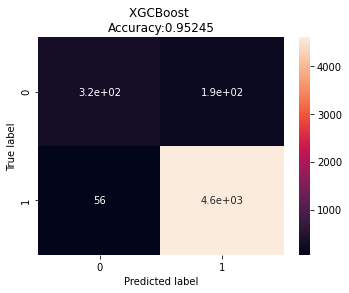

[0.24037057 0.2657337  0.06734852 0.11159668 0.19969903 0.11525147]


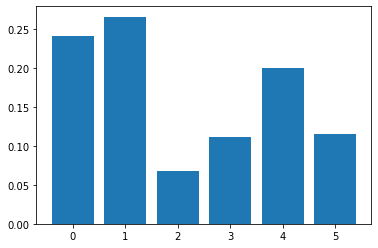

In [10]:

#Train the model using the training sets y_pred=clf.predict(X_test)
model=XGBClassifier(random_state=2, max_depth=4,n_estimators=300,gamma=0.3,learning_rate=0.2,max_delta_step=1)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

# Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns

# Creates a confusion matrix
cm2 = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df2 = pd.DataFrame(cm2)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df2, annot=True)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print('f1: ', f1)
accuracy = accuracy_score(y_test, y_pred)
plt.title('XGCBoost \nAccuracy:{0:.5f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# plot feature importance manually
from numpy import loadtxt
from matplotlib import pyplot
from xgboost import plot_importance
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

# 6.Train model

In [11]:
model = XGBClassifier(random_state=2, max_depth=4,n_estimators=300,gamma=0.3,learning_rate=0.2,max_delta_step=1)
model.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3,
              learning_rate=0.2, max_delta_step=1, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# 7.Test data PreProcessing

In [12]:
#check missing values(no missing values)
test_set.isnull().sum()

#define new feature 'distance'
test_set['distance'] = haversine_vectorize(test_set['pick_lon'],test_set['pick_lat'],test_set['drop_lon'],test_set['drop_lat'])

# dropping features
test_set = test_set.drop(['pick_lat','pick_lon','drop_lat','drop_lon','pickup_time','drop_time','meter_waiting_till_pickup'],axis='columns')

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   additional_fare     8576 non-null   float64
 1   duration            8576 non-null   int64  
 2   meter_waiting       8576 non-null   int64  
 3   meter_waiting_fare  8576 non-null   float64
 4   fare                8576 non-null   float64
 5   distance            8576 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 469.0 KB


# 8. Make Predictions

In [13]:
test = scaler.transform(test_set)
result = model.predict(test)
test_set['prediction'] = result
test_set.head()
final_df = test_set.drop(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'fare', 'distance'],axis='columns')

final_df.head()
datapath = '/content/gdrive/My Drive/Ride_Fare/'
final_df.to_csv(datapath +'submission.csv', index=True)